In [366]:

import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import combinations
import random
import math
import heapq
from matplotlib.patches import FancyArrowPatch
## make the limit of animation size large
plt.rcParams['animation.embed_limit'] = 50
import warnings
warnings.filterwarnings('ignore')


## Ford-Fulkerson Algorithm
Finds a maximal flow in a trafic network

## Algorithm description
The Ford-Fulkerson algorithm determines the maximum flow in a flow network by repetitively finding augmenting paths from a source to a sink. These paths are identified using searches like depth-first search in a special structure called the residual graph, which represents the remaining capacities for each edge after considering the current flow. 

With each found path, the algorithm augments the flow throughout the network, adjusting the residual graph accordingly. This process is repeated until no more augmenting paths can be found in the residual graph, which then signifies that the maximum flow has been reached. The algorithm concludes with this flow value as the maximum flow possible from the source to the sink.


## Instance Maker

### Distance Function

In [18]:
def dist(x,y):
    return math.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)

In [778]:
def make_grid_instance(m:int,n:int,p:float):
    """
    Takes two integers, the dimensions of the grid and a probability p that each edge is included
    """
    nodes=[]
    edges=[]
    for i in range(m):
        for j in range(n):
            if np.random.uniform()<p:
                nodes.append((i,j))
    for u,v in combinations(nodes,2):
        if dist(u,v)==1:
            edges.append((u,v))
    G=nx.DiGraph(edges)
    # Choose starting vertex
    nodes=[node for node in nodes if node in G.nodes()]
    start=G.graph["start"]=nodes[0]
    # Choose ending vertex
    end=G.graph["end"]=nodes[-1] 

    pos={ place:place for place in list(G.nodes()) }
    for u,v in list(G.edges()):
        G[u][v]["capacity"]=np.random.choice(range(1,10))
        G[u][v]["flow"]=0
    for v in list(G.nodes()):
        G.nodes[v]["pos"]=pos[v]
        G.nodes[v]["color"]="deepskyblue"
        G.nodes[v]["node_size"]=80
    G.nodes[start]["color"]="deeppink"
    G.nodes[start]["node_size"]=160
    G.nodes[end]["color"]="palegreen"
    G.nodes[end]["node_size"]=160

    return G

### Draw network graph


In [1638]:
def draw_network_trafic(Graph,ax=None):
    ## define fig
    if ax==None:
        ax=plt.gca()
    #fig=plt.subplots()[0]
    ax.set_facecolor('cornsilk')
    #fig.patch.set_facecolor("cornsilk")
    # get the node colors from the Graph
    node_colors  = nx.get_node_attributes(Graph, 'color')
    node_colors=[node_colors[node] for node in Graph.nodes()]
    # Get the positions from the Graph
    pos  = nx.get_node_attributes(Graph, 'pos')
    # Get the node size from the graph
    node_size=nx.get_node_attributes(Graph, 'node_size')
    node_size=[node_size[node] for node in Graph.nodes()]
    # Get the edge color from the graph
    edge_colors = ["black" if Graph[u][v]["flow"] == 0 else "deeppink" for u, v in Graph.edges()]

    # Draw the nodes and edges
    nx.draw(Graph, pos, with_labels=False, node_color=node_colors, edge_color=edge_colors,node_size=node_size,ax=ax)
#    Create edge labels
    edge_capacity= nx.get_edge_attributes(Graph, 'capacity')
    edge_flow= nx.get_edge_attributes(Graph, 'flow')
    edge_labels={edge:(edge_capacity[edge],edge_flow[edge]) for edge in Graph.edges()}

    # Adjust the edge label positions
    #adjusted_edge_pos_top = adjust_label_pos(G_top,pos_top)

    # Draw edge labels using the original `pos` for nodes and the adjusted `adjusted_edge_pos` for labels
    nx.draw_networkx_edge_labels(Graph,pos=pos, edge_labels=edge_labels,font_size=6,bbox=dict(facecolor='cornsilk'),ax=ax)

In [1642]:
G=make_grid_instance(5,5,0.2)

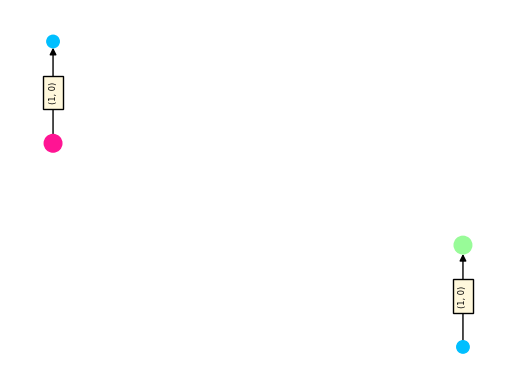

In [1643]:
draw_network_trafic(G)

In [1644]:
G_r=compute_residual_graph(G)

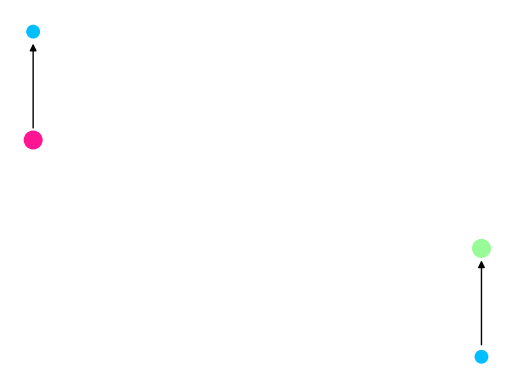

In [1645]:
draw_residual_graph(G_r)

## Residual Graph

### Computing the residual graph from a trafic network and a flow

In [1110]:
# Step 1: Define the residual graph G_f
def compute_residual_graph(G):
    #flow=nx.get_edge_attributes(G,"flow")
    G_f = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        capacity = data['capacity']
        flow=data['flow']
        # Add forward edge with residual capacity
        if capacity>flow:
            G_f.add_edge(u, v, capacity=capacity - flow,direction="forward")
        # Add backward edge for flow cancellation, initially 0 if not present
        if flow>0:
            G_f.add_edge(v, u, capacity=flow,direction="backward")
    ## add position atribute to nodes
    pos=nx.get_node_attributes(G,"pos")
    for v in G_f.nodes():
        G_f.nodes[v]["pos"]=pos[v]
        G_f.nodes[v]["color"]=G.nodes[v]["color"]
        G_f.nodes[v]["node_size"]=G.nodes[v]["node_size"]
    G_f.graph["start"]=G.graph["start"]
    G_f.graph["end"]=G.graph["end"]
    return G_f

In [830]:
G_r=compute_residual_graph(G)

In [801]:
nx.get_node_attributes(G_r,"node_size")

{(0, 0): 160,
 (0, 1): 80,
 (1, 0): 80,
 (0, 2): 80,
 (1, 1): 80,
 (0, 3): 80,
 (1, 2): 80,
 (0, 4): 80,
 (2, 2): 80,
 (1, 4): 80,
 (2, 4): 80,
 (2, 3): 80,
 (3, 2): 80,
 (3, 4): 80,
 (3, 3): 80,
 (4, 2): 80,
 (4, 4): 160,
 (3, 0): 80,
 (4, 0): 80,
 (4, 1): 80}

In [543]:
def shorten_line(u, v, offset=0.1):
    # Calculate the vector from u to v
    vector = np.array(v) - np.array(u)
    
    # Normalize the vector
    norm_vector = vector / np.linalg.norm(vector)
    
    # Calculate new points offset from the original u and v
    new_u = np.array(u) + norm_vector * offset
    new_v = np.array(v) - norm_vector * offset
    
    return new_u, new_v

In [573]:
pos_residual=nx.get_node_attributes(G_r,"pos")

In [678]:
nx.get_node_attributes(G_r,"node_size")

{}

## Draw residual graph

In [1610]:

def draw_residual_graph(G_res,path=[],ax=None):
    # In case axis needs to be speficied
    if ax is None:
        ax = plt.gca()
    ax.axis('off')  # This turns off the bounding box and axes ticks

    # Get positions from graph
    pos=nx.get_node_attributes(G_res, 'pos')
    # Get node_size from graph
    node_size=nx.get_node_attributes(G_res,'node_size')
    node_size=[node_size[node]for node in G_res.nodes()]
    # Get node color from graph
    node_colors=nx.get_node_attributes(G_res, 'color')
    node_colors=[node_colors[node]for node in G_res.nodes()]
    # Draw nodes
    nx.draw_networkx_nodes(G_res, pos, node_color=node_colors,node_size=node_size,ax=ax)
    # Get node directions from graph
    edge_directions = nx.get_edge_attributes(G_res, 'direction')
    # ege colors
    edge_colors={edge:"black" for edge in G_res.edges()}
    for edge in path:
        edge_colors[edge]="deeppink"

    # Draw the edges
    for (u, v), color in edge_directions.items():
        if color == 'forward':
            # Draw straight blue edge
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],arrows=True,edge_color=edge_colors[(u,v)],ax=None)
        elif color == 'backward':
            # Draw curved red edge
            start_pos, end_pos = shorten_line(pos[u], pos[v], offset=0.1)
            arrow = FancyArrowPatch(start_pos,end_pos, connectionstyle='arc3,rad=0.2',
                                    arrowstyle='-|>',mutation_scale=10.0, lw=1,color=edge_colors[(u,v)])
            
            ax.add_patch(arrow)

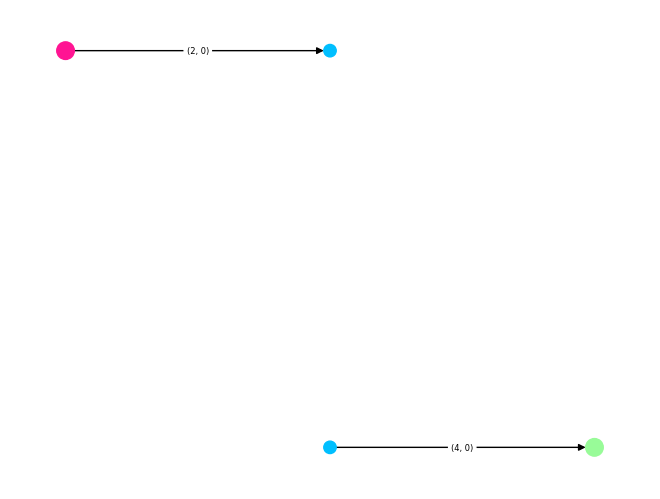

In [1590]:
draw_network_trafic(G)

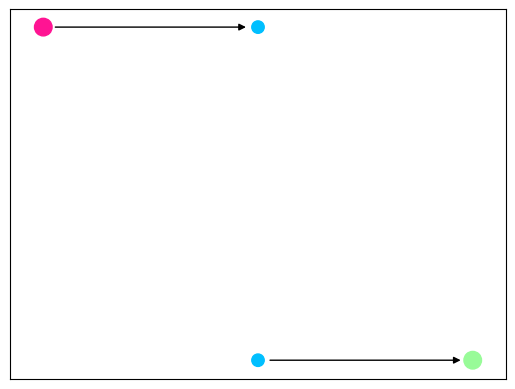

In [1592]:
draw_residual_graph(G_r)

In [1599]:
Gr=compute_residual_graph(G)

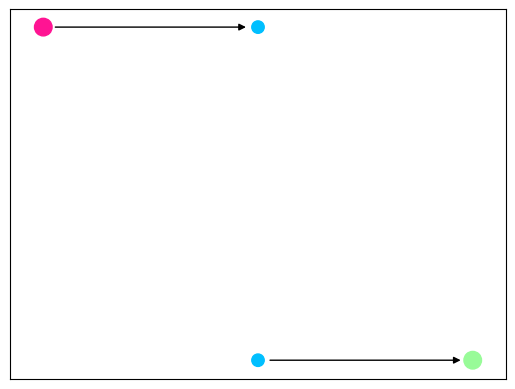

In [1600]:
draw_residual_graph(G_r)

## Find Path in Residual Graph

In [957]:
# Step 2: Find a path from s to t using DFS
def dfs_path(G, s, t, path=[]):
    if s == t:
        return path
    for u, v in G.out_edges(s):
        residual = G[u][v]['capacity']
        if residual > 0 and not (u, v) in path:
            result = dfs_path(G, v, t, path + [(u, v)])
            if result is not None:
                return result


In [878]:
path=dfs_path(G_r,G_r.graph["start"],G_r.graph["end"])

In [879]:
path

[((0, 0), (0, 1)),
 ((0, 1), (0, 2)),
 ((0, 2), (1, 2)),
 ((1, 2), (2, 2)),
 ((2, 2), (3, 2)),
 ((3, 2), (4, 2)),
 ((4, 2), (4, 3))]

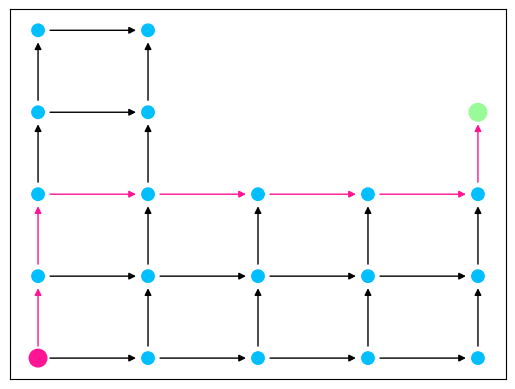

In [884]:
draw_residual_graph(G_r,path)

## Update Network Graph

In [1044]:
def compute_updated_flow(G,G_res, path):
    flow=nx.get_edge_attributes(G,"flow")
    if path is None:
        return G
    # Find the minimum residual capacity of the edges along the path
    bottle_neck = min(G_res[u][v]['capacity'] for (u, v) in path)
    # Update the flow along the path
    for u, v in path:
        if (u, v) in flow:
            flow[(u, v)] += bottle_neck
        else:
            # Initialize reverse flow to 0 if it doesn't exist
            flow.setdefault((v, u), 0)
            flow[(v, u)] -= bottle_neck
        G_updated=G.copy()
        for u,v in G_updated.edges():
            G_updated[u][v]["flow"]=flow[(u,v)]

    return G_updated

In [814]:
flow=nx.get_edge_attributes(G,"flow")

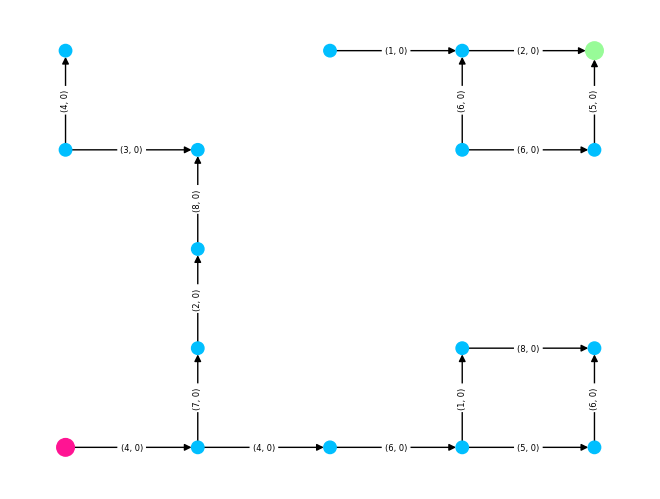

In [949]:
draw_network_trafic(G)

In [936]:
G=make_grid_instance(5,5,0.8)

In [950]:
G_r=compute_residual_graph(G)

In [886]:
G_r=compute_residual_graph(G)

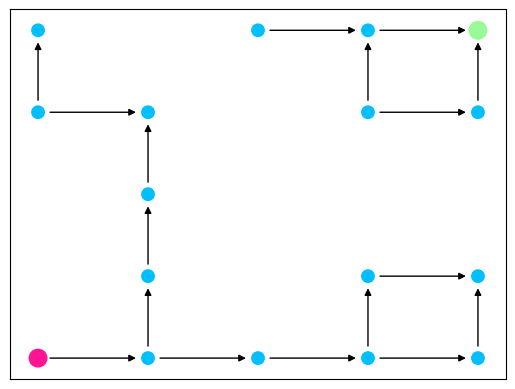

In [951]:
draw_residual_graph(G_r,[])

In [952]:
path=dfs_path(G_r,G_r.graph["start"],G_r.graph["end"])

In [961]:
path is None

True

In [1045]:
G_u=compute_updated_flow(G,G_r,path)

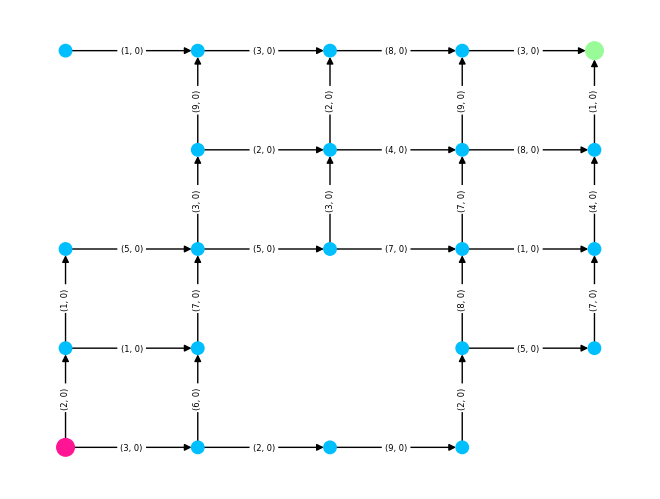

In [1046]:
draw_network_trafic(G_u)

In [1047]:
G_r=compute_residual_graph(G_u)

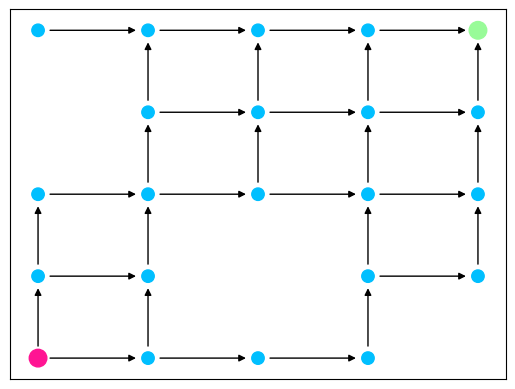

In [1048]:
draw_residual_graph(G_r,[])

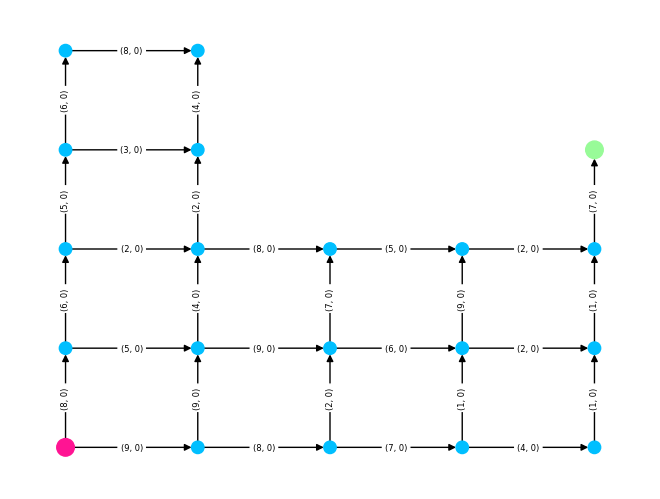

In [890]:
draw_network_trafic(G)

In [891]:
G_r=compute_residual_graph(G)

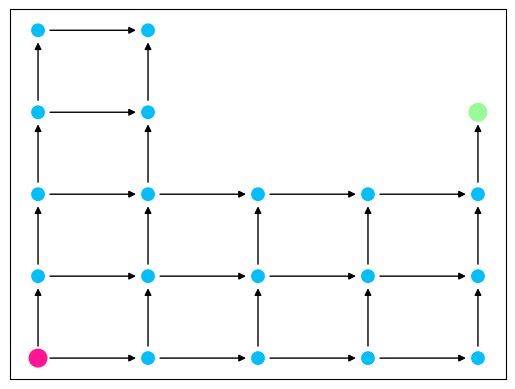

In [892]:
draw_residual_graph(G_r)

In [900]:
path=dfs_path(G_r,G_r.graph["start"],Gr.graph["end"])

In [901]:
path

[]

In [902]:
path

[]

In [907]:
G=compute_updated_flow(G,path)

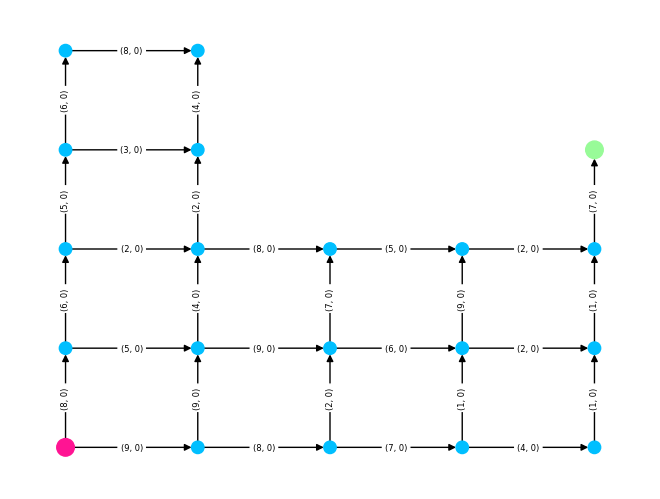

In [846]:
draw_network_trafic(G)

In [1527]:
def frame_min_cut(Graph,Graph_res):
    G=Graph.copy()
    G_res=Graph_res.copy()
        
    visited=path_finder(G_res,G_res.graph["start"])["visited"]
    for v in G_res.nodes():
        if v in visited:
            G_res.nodes[v]["color"]="deeppink"
        else:
            G_res.nodes[v]["color"]="palegreen"
    for v in G.nodes():
        if v in visited:
            G.nodes[v]["color"]="deeppink"
        else:
            G.nodes[v]["color"]="palegreen"
    return G,G_res

## Ford Fulkerson Frames

In [1601]:
def ford_fulkerson_frames(Graph):
    # Initialize flow with 0 for all edges
    #flow = {edge: 0 for edge in G.edges()}
    
    # Create the initial residual graph
    G=Graph.copy()
    start=G.graph["start"]
    end=G.graph["end"]
    G_res = compute_residual_graph(G)
    ans=[]
    # Find a path from source to sink in residual graph
    path=bfs_path(G_res,start,end)
    # In case there is no flow
    if not path:
        ans=[(G.copy(),G_res.copy(),[])]
    while path:
        # add to frames the graph, the residual graph and an empty path
        ans.append((G.copy(),G_res.copy(),[]))
        # Compute updated graph
        G=compute_updated_flow(G,G_res,path)
        # add to frames the graph, the residual graph and the path
        ans.append((G.copy(),G_res.copy(),path))
        # Compute the residual graph
        G_res=compute_residual_graph(G)
        #Compute the path in the residual graph
        path=bfs_path(G_res,start,end)
        
        max_flow = sum(G[u][v]["flow"] for u,v in list(G.out_edges(start)))
        print(max_flow)
    G,G_res=frame_min_cut(G,G_res)
    ans.append((G.copy(),G_res.copy(),[]))

    return ans

In [1529]:
def path_finder(Graph,start):
    """
    Takes a directed graph and a starting node. Returns a dictionary with keys:
    "level": a list of sets, the new nodes that can be visited on each step
    "predecesor": A dictionary that assigns the predecesor to each visited node
    "visited": The list of visited nodes 
    """
    level=[{start}]
    visited={start}
    next_level={start}
    predecesor=dict()
    predecesor[start]=None
    while next_level:
        level.append(next_level)
        visited=visited.union(next_level)
        new=set()
        for node in next_level:
            new_neighbors={vertex for vertex in Graph.successors(node) if vertex not in visited}
            visited=visited.union(new_neighbors)
            for vertex in new_neighbors:
                predecesor[vertex]=node
            new=new.union(new_neighbors)
        next_level=new
    ans=dict()
    ans["level"]=level
    ans["predecessor"]=predecesor
    ans["visited"]=visited
    return ans


In [1394]:
def shortest_path(predecessors, start, end):
    """
    Reconstruct the shortest path from the predecessors.

    Parameters:
    - predecessors: a dictionary with the preceding node in the shortest path
    - start: the starting node
    - end: the ending node

    Returns:
    - path: list of nodes representing the shortest path from start to end
    """
    path = [end]
    while path[-1] != start:
        path.append(predecessors[path[-1]])
    path.reverse()
    return path

In [1446]:
def bfs_path(graph,start,end):
    search_results=path_finder(graph,start)
    predecessors= search_results["predecessor"]
    visited=search_results["visited"]
   
    if end not in visited:
        return None
    else:
        sequence= shortest_path(predecessors,start,end)
        k=len(sequence)
        return [(sequence[i],sequence[i+1]) for i in range(k-1)]

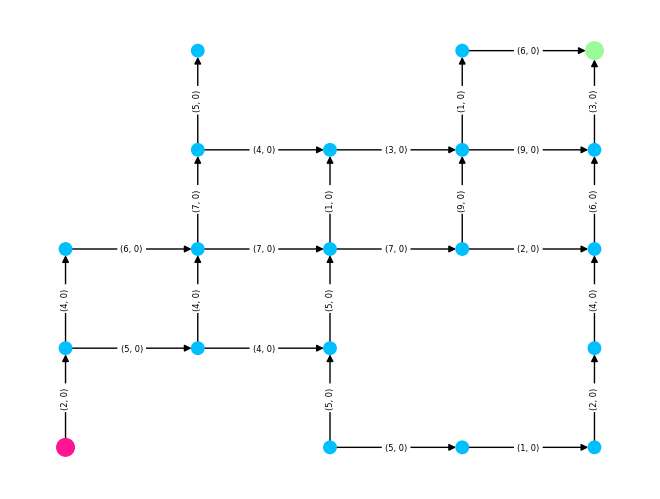

In [1602]:
G=make_grid_instance(5,5,0.8)
draw_network_trafic(G)

In [1427]:
u,v=list(G.nodes())[0],list(G.nodes())[-1]


In [1428]:
u,v

((0, 0), (4, 4))

In [1511]:
bfs_path(G,u,v)

(4, 3)

In [1274]:
max_flow = sum(G[u][v]["flow"] for u,v in list(G.out_edges((1,1))))

In [1549]:
G=make_grid_instance(8,8,0.9)

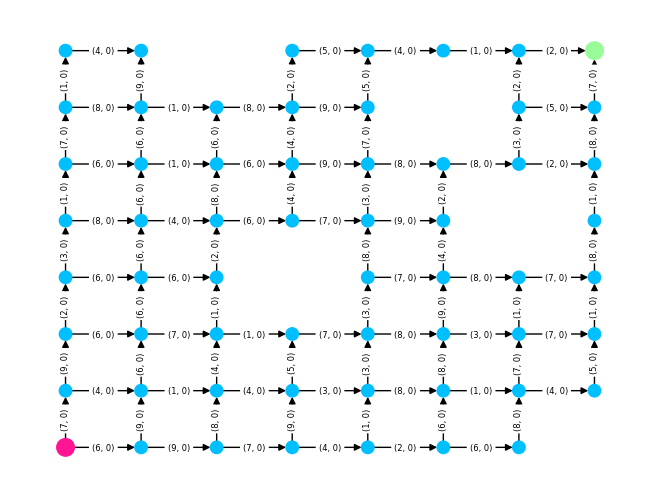

In [1550]:
draw_network_trafic(G)

In [1551]:
frames=ford_fulkerson_frames(G)

1
2
3
4
5
6
7


In [1552]:
len(frames)

15

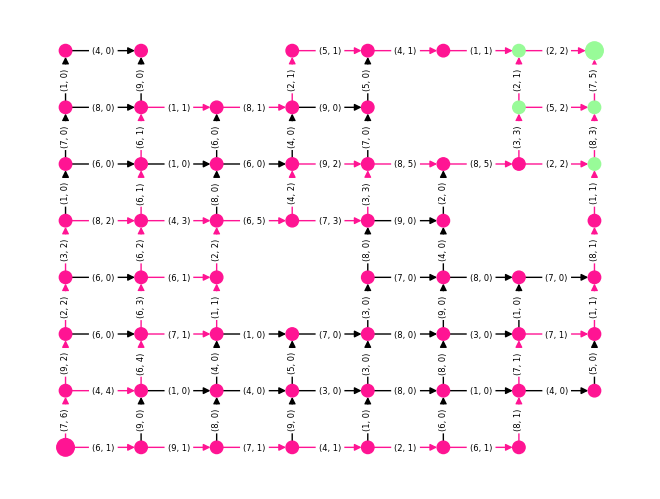

In [1553]:
k=len(frames)-1

draw_network_trafic(frames[k][0])

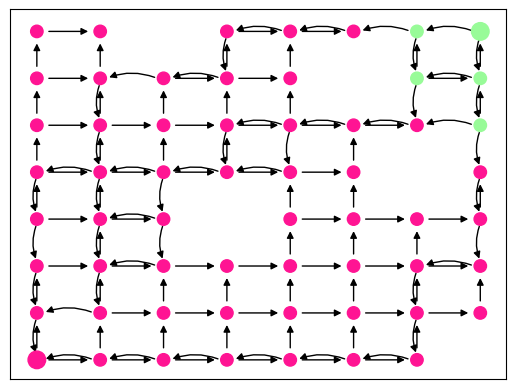

In [1554]:

draw_residual_graph(frames[k][1],frames[k][2])

## Label Positions

In [167]:
def adjust_label_pos(Graph,pos, x_offset=0.1, y_offset=0.1):
    label_pos = {}
    for edge in Graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        label_pos[edge] = ((x0 + x1) / 2 + x_offset, (y0 + y1) / 2 + y_offset)
    return label_pos

In [277]:
ans_top=make_grid_instance(5,5,0.85)
G_top,pos_top=ans_top["graph"],ans_top["pos"]

ans_bottom=make_grid_instance(5,5,0.85)
G_bottom,pos_bottom=ans_bottom["graph"],ans_bottom["pos"]

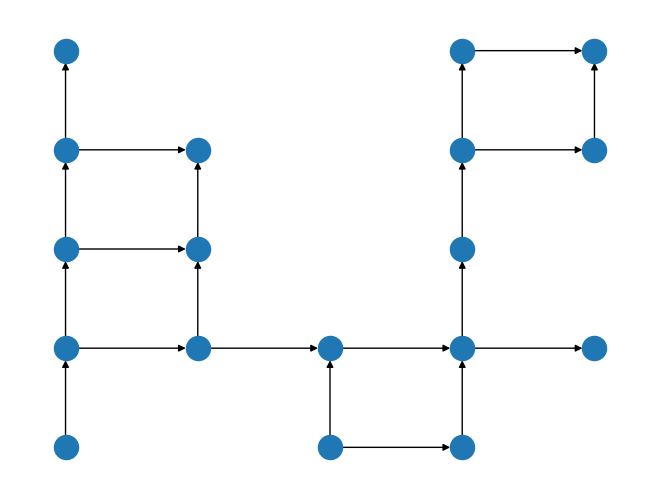

In [149]:
nx.draw(G_top,pos_top)

In [166]:
print("Nodes in the graph:", G_top.nodes())
print("Nodes in the pos dictionary:", pos_top.keys())


Nodes in the graph: [(0, 0), (0, 1), (0, 2), (1, 1), (0, 3), (1, 2), (0, 4), (1, 3), (2, 1), (2, 0), (3, 0), (3, 1), (3, 2), (4, 1), (3, 3), (3, 4), (4, 3), (4, 4)]
Nodes in the pos dictionary: dict_keys([(0, 0), (0, 1), (0, 2), (1, 1), (0, 3), (1, 2), (0, 4), (1, 3), (2, 1), (2, 0), (3, 0), (3, 1), (3, 2), (4, 1), (3, 3), (3, 4), (4, 3), (4, 4)])


In [193]:
set(adjust_label_pos(G_top,pos_top).keys())==set(G_top.edges())

True

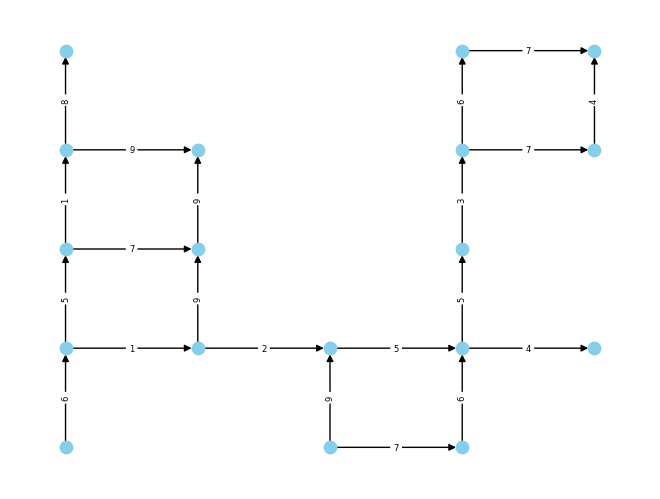

In [231]:

# Draw the nodes and edges
nx.draw(G_top, pos_top, with_labels=False, node_color='skyblue', node_size=80)
#    Create edge labels
edge_labels = nx.get_edge_attributes(G_top, 'capacity')

# # Adjust the edge label positions
# adjusted_edge_pos_top = adjust_label_pos(G_top,pos_top)

# Draw edge labels using the original `pos` for nodes and the adjusted `adjusted_edge_pos` for labels
_=nx.draw_networkx_edge_labels(G_top,pos=pos_top,edge_labels=edge_labels,font_size=6)

In [1650]:
def animate_ford_fulkerson(G):

    # Create a figure and two subplots
    fig, axs = plt.subplots(2, 1, figsize=(7, 7))
    fig.set_facecolor('cornsilk')
    ax0 = axs[0]
    ax1 =axs[1]
    frames=ford_fulkerson_frames(G)
    def update(frame):
        # Clear the previous drawings
        axs[0].clear()
        axs[1].clear()
        draw_network_trafic(frame[0],ax=ax0)
        draw_residual_graph(frame[1],frame[2],ax=ax1)


        # Set titles
        axs[0].set_title('Trafic Network')
        axs[1].set_title('Residual Graph')
        fig.suptitle('Ford Fulkerson algorithm', fontsize=16)
        #axs.set_title("Hola")
    # Create an animation
    ani = FuncAnimation(fig, update, frames=frames, interval=1000, repeat=True)

    ani_jshtml = ani.to_jshtml()
        #print(frames)
        # Display the animation
    return(HTML(ani_jshtml))

In [1651]:
G=make_grid_instance(5,5,0.8)

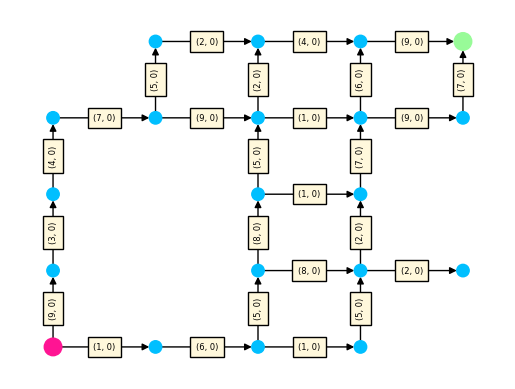

In [1652]:
draw_network_trafic(G)

2
3
4


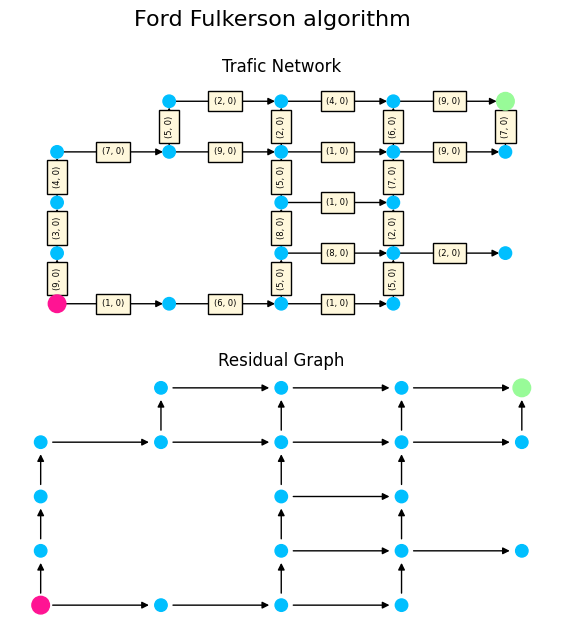

In [1653]:
animate_ford_fulkerson(G)

In [1570]:
def make_something(ax):
    return draw_network_trafic(G)

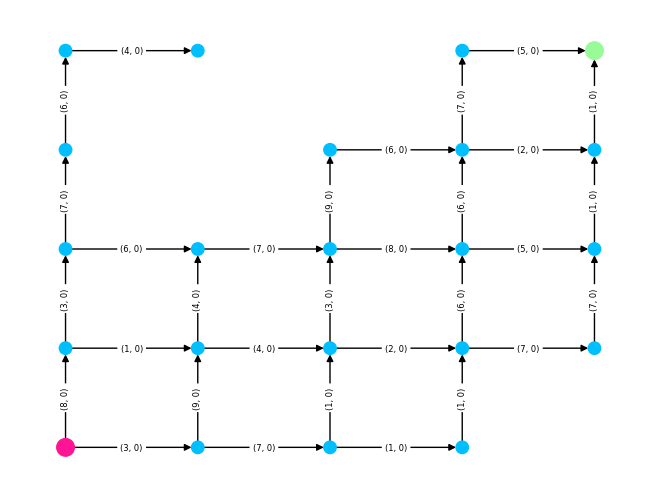

In [1573]:
make_something()

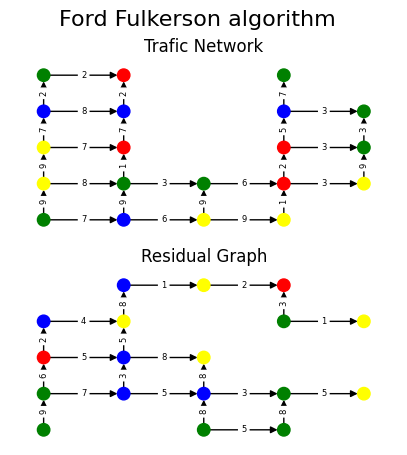

In [279]:


# # Create two random graphs
# G_top = nx.erdos_renyi_graph(n=10, p=0.5)
# G_bottom = nx.erdos_renyi_graph(n=10, p=0.5)

# # Position the nodes using one of the layout options e.g. spring_layout
# pos_top = nx.spring_layout(G_top)
# pos_bottom = nx.spring_layout(G_bottom)

# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(5, 5))
ax0 = axs[0]
ax1 =axs[1]
def update(frame):
    # Clear the previous drawings
    axs[0].clear()
    axs[1].clear()

    # Draw the top graph with random colors for nodes
    node_colors_top = [random.choice(['red', 'green', 'blue', 'yellow']) for _ in G_top.nodes()]
    # Draw the nodes and edges
    nx.draw(G_top, pos_top, with_labels=False, node_color=node_colors_top, node_size=80,ax=ax0)
#    Create edge labels
    edge_labels_top = nx.get_edge_attributes(G_top, 'capacity')

    # Adjust the edge label positions
    #adjusted_edge_pos_top = adjust_label_pos(G_top,pos_top)

    # Draw edge labels using the original `pos` for nodes and the adjusted `adjusted_edge_pos` for labels
    nx.draw_networkx_edge_labels(G_top,pos=pos_top, edge_labels=edge_labels_top,font_size=6,ax=ax0)

    # Draw the bottom graph with random colors for nodes
    node_colors_bottom = [random.choice(['red', 'green', 'blue', 'yellow']) for _ in G_bottom.nodes()]
    nx.draw(G_bottom, pos_bottom, with_labels=False, node_color=node_colors_bottom, node_size=80,ax=ax1)
#    Create edge labels
    edge_labels_bottom = nx.get_edge_attributes(G_bottom, 'capacity')

    # Adjust the edge label positions
    #adjusted_edge_pos_bottom = adjust_label_pos(G_bottom,pos_bottom)

    # Draw edge labels using the original `pos` for nodes and the adjusted `adjusted_edge_pos` for labels
    nx.draw_networkx_edge_labels(G_bottom,pos=pos_bottom,label_pos=0.5,edge_labels=edge_labels_bottom,font_size=6,ax=ax1)
    #nx.draw_networkx_edge_labels(G_bottom, pos=pos_bottom,edge_labels=edge_labels,font_size=6,ax=ax1)


    # Set titles
    axs[0].set_title('Trafic Network')
    axs[1].set_title('Residual Graph')
    fig.suptitle('Ford Fulkerson algorithm', fontsize=16)
    #axs.set_title("Hola")
# Create an animation
ani = FuncAnimation(fig, update, frames=10, interval=1000, repeat=True)

ani_jshtml = ani.to_jshtml()
    #print(frames)
    # Display the animation
def thing():
    return(HTML(ani_jshtml))


In [280]:
thing()

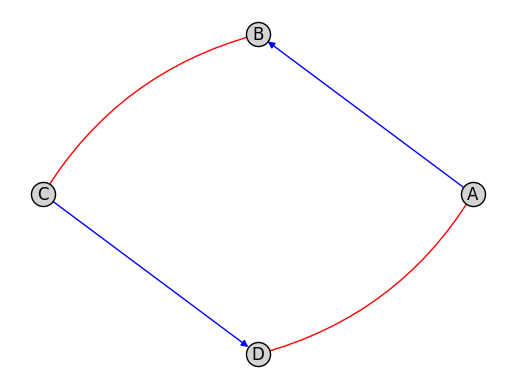

In [283]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges with a color attribute
G.add_edge('A', 'B', color='blue')
G.add_edge('B', 'C', color='red')
G.add_edge('C', 'D', color='blue')
G.add_edge('D', 'A', color='red')

# Define positions for nodes
pos = nx.circular_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightgrey', edgecolors='black')

# Draw the node labels
nx.draw_networkx_labels(G, pos)

# Extract edge colors from the edge attributes
edge_colors = nx.get_edge_attributes(G, 'color')

# Draw the edges
for (u, v), color in edge_colors.items():
    if color == 'blue':
        # Draw straight blue edge
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color)
    elif color == 'red':
        # Draw curved red edge
        arrow = FancyArrowPatch(pos[u], pos[v], connectionstyle='arc3,rad=0.2',
                                arrowstyle='-|>', color=color, mutation_scale=10.0, lw=1)
        plt.gca().add_patch(arrow)

# Set axis off and show plot
plt.axis('off')
plt.show()

In [512]:
def shorten_line(u, v, offset=0.1):
    # Calculate the vector from u to v
    vector = np.array(v) - np.array(u)
    
    # Normalize the vector
    norm_vector = vector / np.linalg.norm(vector)
    
    # Calculate new points offset from the original u and v
    new_u = np.array(u) + norm_vector * offset
    new_v = np.array(v) - norm_vector * offset
    
    return new_u, new_v

In [376]:
ans_top=make_grid_instance(5,5,0.85)
G,pos=ans_top["graph"],ans_top["pos"]

color_edge_dict={edge:random.choice(["forward","backward"]) for edge in G.edges()}
# Now, you want to add or change the color of an existing edge
nx.set_edge_attributes(G, color_edge_dict, 'direction')

In [406]:
G=make_grid_instance(5,5,0.5)

In [ ]:
start=nodes

## Draw residual Graph

In [357]:


# Define positions for nodes
#pos = nx.circular_layout(G)
def draw_residual_graph(G_residual,pos_residual,start, end):
    # Draw the nodes
    node_size={node:80 for node in G.nodes()}
    node_size[start]=200
    node_size[end]=200
    node_size=[node_size[node]for node in G.nodes()]
    node_colors={node:"deepskyblue" for node in G.nodes()}
    node_colors[start]="deeppink"
    node_colors[end]="palegreen"
    node_colors=[node_colors[node]for node in G.nodes()]
    fig, ax = plt.subplots()
     # format figure
    fig.set_facecolor('cornsilk')
    ax.set_facecolor('cornsilk')
     # List of points
    nx.draw_networkx_nodes(G_residual, pos_residual, node_color=node_colors, edgecolors='black',node_size=node_size)

    # Draw the node labels
    #nx.draw_networkx_labels(G, pos)

    # Extract edge colors from the edge attributes
    edge_colors = nx.get_edge_attributes(G_residual, 'direction')

    # Draw the edges
    for (u, v), color in edge_colors.items():
        if color == 'forward':
            # Draw straight blue edge
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], arrows=True)
        elif color == 'backward':
            # Draw curved red edge
            start_pos, end_pos = shorten_line(pos[u], pos[v], offset=0.1)
            arrow = FancyArrowPatch(start_pos,end_pos, connectionstyle='arc3,rad=0.2',
                                    arrowstyle='-|>', mutation_scale=10.0, lw=1)
            plt.gca().add_patch(arrow)

    # Set axis off and add a margin to ensure arrows are not clipped
    plt.axis('off')
    plt.margins(0.1)

    plt.show()


## Draw Trafic Network

In [363]:
start=list(G.nodes())[0]
end=list(G.nodes())[-1]

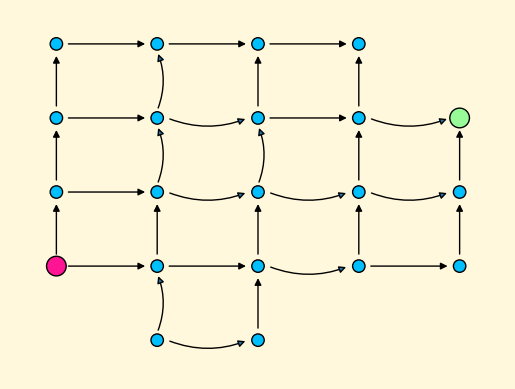

In [367]:
draw_residual_graph(G,pos,start,end)

In [393]:
list(G.edges(data=True))[0]

((0, 0), (0, 1), {'capacity': 8, 'direction': 'forward'})

### Ford Fulkerson Algorithm

In [389]:

# Step 1: Define the residual graph G_f
def create_residual_graph(G, flow):
    G_f = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        capacity = data['capacity']
        # Add forward edge with residual capacity
        G_f.add_edge(u, v, capacity=capacity - flow.get((u, v), 0))
        # Add backward edge for flow cancellation, initially 0 if not present
        G_f.add_edge(v, u, capacity=flow.get((v, u), 0))
    return G_f

# Step 2: Find a path from s to t using DFS
def dfs_path(G, s, t, path=[]):
    if s == t:
        return path
    for u, v in G.out_edges(s):
        residual = G[u][v]['capacity']
        if residual > 0 and not (u, v) in path:
            result = dfs_path(G, v, t, path + [(u, v)])
            if result is not None:
                return result

# Step 3: Given a path in the residual graph, update the flow f to f'
# Step 3: Given a path in the residual graph, update the flow f to f'
def update_flow(G, flow, path):
    # Find the minimum residual capacity of the edges along the path
    min_residual = min(G[u][v]['capacity'] for u, v in path)
    # Update the flow along the path
    for u, v in path:
        if (u, v) in flow:
            flow[(u, v)] += min_residual
        else:
            # Initialize reverse flow to 0 if it doesn't exist
            flow.setdefault((v, u), 0)
            flow[(v, u)] -= min_residual
    return flow


# Ford-Fulkerson algorithm implementation
def ford_fulkerson(G, source, sink):
    # Initialize flow with 0 for all edges
    flow = {edge: 0 for edge in G.edges()}
    
    # Create the initial residual graph
    residual_graph = create_residual_graph(G, flow)
    
    # Find a path from source to sink
    path = dfs_path(residual_graph, source, sink)
    
    while path:
        # Find the minimum residual capacity of the edges along the path
        min_residual = min(residual_graph[u][v]['capacity'] for u, v in path)
        
        # Update the flow along the path
        for u, v in path:
            if (u, v) in flow:
                flow[(u, v)] += min_residual
            else:
                flow[(v, u)] -= min_residual
        
        # Rebuild the residual graph after the flow update
        residual_graph = create_residual_graph(G, flow)
        
        # Look for another path
        path = dfs_path(residual_graph, source, sink)
    
    # Calculate the max flow by summing the flow on the edges out of the source
    max_flow = sum(flow[edge] for edge in G.edges(source))
    return max_flow





In [400]:
# Step 1: Define the residual graph G_f
def create_residual_graph(G, flow):
    G_f = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        capacity = data['capacity']
        # Add forward edge with residual capacity
        G_f.add_edge(u, v, capacity=capacity - flow.get((u, v), 0),direction="forward")
        # Add backward edge for flow cancellation, initially 0 if not present
        G_f.add_edge(v, u, capacity=flow.get((v, u), 0),direction="backward")
    return G_f

In [394]:
def ford_fulkerson_frames(G, source, sink):
    # Initialize flow with 0 for all edges
    flow = {edge: 0 for edge in G.edges()}
    
    # Create the initial residual graph
    residual_graph = create_residual_graph(G, flow)
    ans=[(flow.copy(),residual_graph.copy())]
    # Find a path from source to sink
    path = dfs_path(residual_graph, source, sink)
    
    while path:
        # Find the minimum residual capacity of the edges along the path
        min_residual = min(residual_graph[u][v]['capacity'] for u, v in path)
        
        # Update the flow along the path
        for u, v in path:
            if (u, v) in flow:
                flow[(u, v)] += min_residual
            else:
                flow[(v, u)] -= min_residual
        
        # Rebuild the residual graph after the flow update
        residual_graph = create_residual_graph(G, flow)
        ans.append((flow.copy(),residual_graph.copy()))
        # Look for another path
        path = dfs_path(residual_graph, source, sink)
    
    # Calculate the max flow by summing the flow on the edges out of the source
    max_flow = sum(flow[edge] for edge in G.edges(source))
    return max_flow,ans

In [402]:
G=ford_fulkerson_frames(G,start,end)[1][0][1]

In [387]:
G.nodes

NodeView(((0, 0), (0, 1), (1, 0), (0, 2), (1, 1), (0, 3), (1, 2), (0, 4), (1, 3), (1, 4), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 3), (4, 0), (3, 2), (4, 1), (4, 2), (3, 4), (4, 3), (4, 4)))

In [384]:
_=nx.draw(G, pos, with_labels=False, node_size=80,ax=ax1)
#Create edge labels
edge_labels = nx.get_edge_attributes(G, 'capacity')

    # Adjust the edge label positions
    #adjusted_edge_pos_bottom = adjust_label_pos(G_bottom,pos_bottom)

    # Draw edge labels using the original `pos` for nodes and the adjusted `adjusted_edge_pos` for labels
#_=nx.draw_networkx_edge_labels(G,pos=pos,label_pos=0.5,edge_labels=edge_labels,font_size=6,ax=ax1)

In [385]:
_